<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/CNN_cifar_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import random
import torch
from torch import nn,optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
train_on_gpu=torch.cuda.is_available()

if not train_on_gpu:
  torch.manual_seed(42)
  print('cuda is not available! train on cpu...')
else:
  torch.cuda.manual_seed(42)
  print('cuda is available! train on gpu...')
np.random.seed(42)
random.seed(42)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda is available! train on gpu...


# 1 准备数据以及数据增强

In [8]:
trans=transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_data=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=trans)
test_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=trans)

Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified


In [9]:
len(train_data),len(test_data)

(50000, 10000)

In [0]:
batch_size=128
indices=list(range(len(train_data)))
np.random.shuffle(indices)
valid_ratio=0.2
valid_num=int(valid_ratio*len(train_data))
valid_idx=indices[:valid_num]
train_idx=indices[valid_num:]
valid_data=[train_data[i] for i in valid_idx]
train_data=[train_data[i] for i in train_idx]
train_iter=Data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=4)
valid_iter=Data.DataLoader(valid_data,batch_size=batch_size,num_workers=4)
test_iter=Data.DataLoader(test_data,batch_size=batch_size,num_workers=4)

# 2 整体认知数据

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

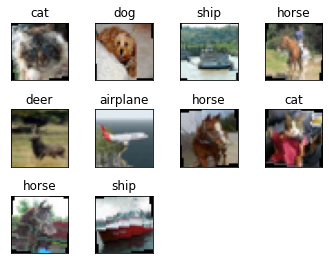

In [55]:
import math
def show(data_iter,show_num):
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  # show_num=20
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.2,top=1,hspace=0.5,wspace=0.05)
  show_idx=np.random.choice(batch_size,show_num)
  rows=int(np.sqrt(show_num))
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[show_idx[i]].permute(1,2,0).numpy()/2+0.5)
    ax.set_title(classes[int(label[show_idx[i]].item())])
show(train_iter,10)

# 3 建立模型

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(3,16,3,padding=1)
    self.conv2=nn.Conv2d(16,32,3,padding=1)
    self.conv3=nn.Conv2d(32,64,3,padding=1)
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(64*4*4,500)
    self.fc2=nn.Linear(500,10)
    self.dropout=nn.Dropout(0.25)
  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=x.view(x.shape[0],-1)
    x=self.dropout(x)
    x=F.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x

# 4 训练网络

In [0]:
def evaluate_acc(model,data_iter):
  acc,n=0.0,0
  model.eval()
  with torch.no_grad():
    for X,Y in data_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      acc+=(y_pred.argmax(dim=1)==Y).sum().item()
      n+=Y.shape[0]
  return acc/n

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.CrossEntropyLoss()
  optimizer=optim.Adam(model.parameters(),lr=lr)
  valid_min_loss=np.inf
  train_list,valid_list=[],[]
  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      train_list.append(loss.item())
    model.eval()
    for X,Y in valid_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      valid_loss+=loss.item()*X.shape[0]
      valid_list.append(loss.item())
    train_loss=train_loss/len(train_data)
    valid_loss=valid_loss/len(valid_data)
    train_acc=evaluate_acc(model,train_iter)
    valid_acc=evaluate_acc(model,valid_iter)
    if valid_loss<valid_min_loss:
      print('validation loss decreased({:.6f}-->{:.6f})'.format(valid_min_loss,valid_loss))
      valid_min_loss=valid_loss
      torch.save(model.state_dict(),'model.pt')
    print('epoch:{},train loss:{},valid loss:{},train acc:{},valid acc:{}'\
          .format(epoch+1,train_loss,valid_loss,train_acc,valid_acc))
  return train_list,valid_list

In [48]:
model=Net()
num_epochs=10
lr=0.001
train_list,valid_list=train(model,num_epochs,lr,train_iter,valid_iter)

validation loss decreased(inf-->1.380566)
epoch:1,train loss:1.6627833631515503,valid loss:1.380566194152832,train acc:0.50295,valid acc:0.4982
validation loss decreased(1.380566-->1.201513)
epoch:2,train loss:1.3162744497299195,valid loss:1.2015132965087891,train acc:0.58925,valid acc:0.5729
validation loss decreased(1.201513-->1.113487)
epoch:3,train loss:1.182742135620117,valid loss:1.1134868446350097,train acc:0.623975,valid acc:0.6048
validation loss decreased(1.113487-->1.052364)
epoch:4,train loss:1.0793663228988648,valid loss:1.0523642259597779,train acc:0.65975,valid acc:0.6288
validation loss decreased(1.052364-->0.980854)
epoch:5,train loss:1.0041396873474122,valid loss:0.9808541482925415,train acc:0.6916,valid acc:0.6526
validation loss decreased(0.980854-->0.977475)
epoch:6,train loss:0.945843295288086,valid loss:0.977474521446228,train acc:0.704875,valid acc:0.6562
validation loss decreased(0.977475-->0.905414)
epoch:7,train loss:0.8909060346603394,valid loss:0.9054140927

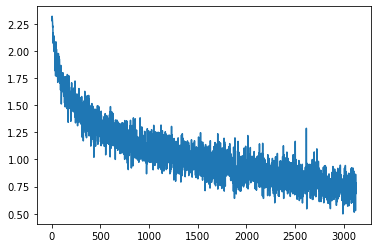

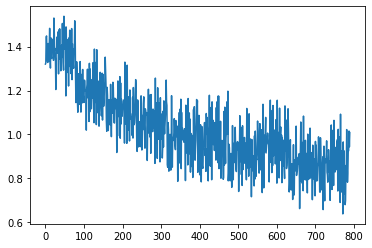

In [49]:
plt.plot(range(len(train_list)),train_list)
plt.figure()
plt.plot(range(len(valid_list)),valid_list)

# 5 测试

In [51]:
model.load_state_dict(torch.load('model.pt'))
print('test acc:',evaluate_acc(model,test_iter))


test acc: 0.6972


In [0]:
def predict(model,data_iter,show_num):
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  # show_num=20
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.2,top=1,hspace=0.5,wspace=0.5)
  show_idx=np.random.choice(batch_size,show_num)
  rows=int(np.sqrt(show_num))
  cols=math.ceil(show_num/rows)
  pred=model(img.to(device)).argmax(dim=1)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[show_idx[i]].permute(1,2,0).numpy()/2+0.5)
    ax.set_title('{}({})'.format(classes[int(label[show_idx[i]].item())],\
        classes[int(pred[show_idx[i]].item())]),\
        c=('green' if label[show_idx[i]]==pred[show_idx[i]] else 'red'))

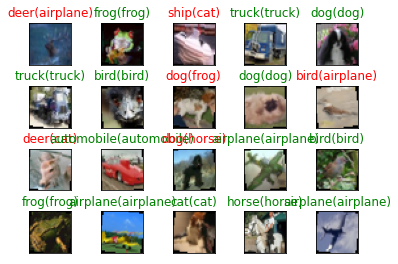

In [70]:
predict(model,test_iter,20)

# 6 迁移学习

## 6.1 准备数据（这里需要将数据按模型要求作预处理）

In [3]:
trans=transforms.Compose([
  transforms.Resize(size=224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
train_data=torchvision.datasets.CIFAR10(root='./trans_data',train=True,download=True,transform=trans)
test_data=torchvision.datasets.CIFAR10(root='./trans_data',train=False,download=True,transform=trans)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_data),len(test_data)
idx_train=list(range(len(train_data)))
np.random.shuffle(idx_train)
idx_test=list(range(len(test_data)))
np.random.shuffle(idx_test)
train_data=[train_data[i] for i in idx_train[:2000]]
test_data=[test_data[i] for i in idx_test[:500]]
len(train_data),len(test_data)

(2000, 500)

In [0]:
batch_size=20
indices=list(range(len(train_data)))
valid_ratio=0.2
valid_num=int(valid_ratio*len(train_data))
valid_idx=indices[:valid_num]
train_idx=indices[valid_num:]
valid_data=[train_data[i] for i in valid_idx]
train_data=[train_data[i] for i in train_idx]
train_iter=Data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=4)
valid_iter=Data.DataLoader(valid_data,batch_size=batch_size,num_workers=4)
test_iter=Data.DataLoader(test_data,batch_size=batch_size,num_workers=4)

In [6]:
len(train_data),len(valid_data),len(test_data)

(1600, 400, 500)

## 6.2 整体认知数据

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

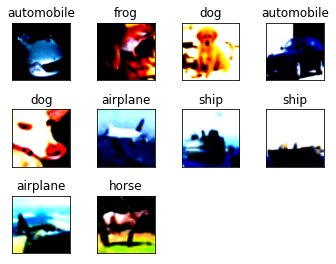

In [8]:
import math
def show(data_iter,show_num):
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  # show_num=20
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.2,top=1,hspace=0.5,wspace=0.05)
  show_idx=np.random.choice(batch_size,show_num)
  rows=int(np.sqrt(show_num))
  cols=math.ceil(show_num/rows)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[show_idx[i]].permute(1,2,0).numpy())
    ax.set_title(classes[int(label[show_idx[i]].item())])
show(valid_iter,10)

## 6.3 模型

In [0]:
import torchvision.models as models
model=models.resnet18(pretrained=True)

In [10]:
model.fc=nn.Linear(512,10)
print(model.fc)

Linear(in_features=512, out_features=10, bias=True)


In [0]:
# 不同层设置不同学习率
# output_params=list(map(id,model.fc.parameters()))
# feature_params=filter(lambda p:id(p) not in output_params,model.parameters())

In [0]:
# 只训练线性层
for name,p in model.named_parameters():
  if name.startswith('fc'):
    continue
  else:
    p.requires_grad=False 

In [0]:
def evaluate_acc(model,data_iter):
  acc,n=0.0,0
  model.eval()
  with torch.no_grad():
    for X,Y in data_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      acc+=(y_pred.argmax(dim=1)==Y).sum().item()
      n+=Y.shape[0]
  return acc/n

In [0]:
def train(model,num_epochs,lr,train_iter,valid_iter):
  model=model.to(device)
  criterion=nn.CrossEntropyLoss()
  # 不同层设置不同的学习率
  # optimizer=optim.Adam([{'params':feature_params},
            #  {'params':model.fc.parameters(),'lr':lr*10}],lr=lr,weight_decay=0.001)
  # 只训练线性层
  optimizer=optim.Adam(model.parameters())
  valid_min_loss=np.inf
  train_list,valid_list=[],[]
  for epoch in range(num_epochs):
    train_loss,valid_loss=0.0,0.0
    model.train()
    for X,Y in train_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*X.shape[0]
      train_list.append(loss.item())
    model.eval()
    for X,Y in valid_iter:
      X=X.to(device)
      Y=Y.to(device)
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      valid_loss+=loss.item()*X.shape[0]
      valid_list.append(loss.item())
    train_loss=train_loss/len(train_data)
    valid_loss=valid_loss/len(valid_data)
    train_acc=evaluate_acc(model,train_iter)
    valid_acc=evaluate_acc(model,valid_iter)
    if valid_loss<valid_min_loss:
      print('validation loss decreased({:.6f}-->{:.6f})'.format(valid_min_loss,valid_loss))
      valid_min_loss=valid_loss
      torch.save(model.state_dict(),'trans_model.pt')
    print('epoch:{},train loss:{},valid loss:{},train acc:{},valid acc:{}'\
          .format(epoch+1,train_loss,valid_loss,train_acc,valid_acc))
  return train_list,valid_list


In [14]:
num_epochs=10
lr=0.001
train_list,valid_list=train(model,num_epochs,lr,train_iter,valid_iter)

validation loss decreased(inf-->1.348748)
epoch:1,train loss:1.8204868137836456,valid loss:1.3487482607364654,train acc:0.6225,valid acc:0.5725
validation loss decreased(1.348748-->1.082229)
epoch:2,train loss:1.1959908686578273,valid loss:1.0822287440299987,train acc:0.715625,valid acc:0.65
validation loss decreased(1.082229-->0.938615)
epoch:3,train loss:0.9704129979014396,valid loss:0.9386149793863297,train acc:0.764375,valid acc:0.7
validation loss decreased(0.938615-->0.822514)
epoch:4,train loss:0.8543164096772671,valid loss:0.822513535618782,train acc:0.799375,valid acc:0.735
validation loss decreased(0.822514-->0.775063)
epoch:5,train loss:0.7776169501245022,valid loss:0.7750630646944046,train acc:0.824375,valid acc:0.7325
epoch:6,train loss:0.7256558936089277,valid loss:0.7865252614021301,train acc:0.830625,valid acc:0.7325
validation loss decreased(0.775063-->0.766623)
epoch:7,train loss:0.7011876177042723,valid loss:0.7666226953268052,train acc:0.83,valid acc:0.75
validation

In [16]:
model.load_state_dict(torch.load('trans_model.pt'))

<All keys matched successfully>

In [17]:
print('test acc:',evaluate_acc(model,test_iter))

test acc: 0.784


In [0]:
def predict(model,data_iter,show_num):
  show_iter=iter(data_iter)
  show_some=next(show_iter)
  img,label=show_some
  # show_num=20
  fig=plt.figure()
  fig.subplots_adjust(bottom=0.2,top=1,hspace=0.5,wspace=0.5)
  show_idx=np.random.choice(batch_size,show_num)
  rows=int(np.sqrt(show_num))
  cols=math.ceil(show_num/rows)
  pred=model(img.to(device)).argmax(dim=1)
  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(img[show_idx[i]].permute(1,2,0).numpy()/2+0.5)
    ax.set_title('{}({})'.format(classes[int(label[show_idx[i]].item())],\
        classes[int(pred[show_idx[i]].item())]),\
        c=('green' if label[show_idx[i]]==pred[show_idx[i]] else 'red'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

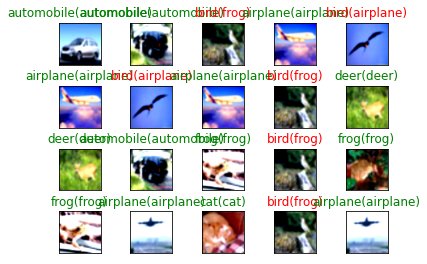

In [20]:
predict(model,test_iter,20)